# 1. Configuración del ambiente



>Variables globales


1.   df_bitcoin: Este variable tiene el dataframe de los precios historicos del bitcoin
2.   precio_actual: precio actual del bitcoin
3.  tendencia: si el precio del bitcoin es alta o baja
4. algoritmo_decision: tomara variables Ignorar, Comprar o Vender

*   Elemento de la lista
*   Elemento de la lista





In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import yfinance as yf
import time
##conectando colab con drive
from google.colab import drive
from IPython.display import clear_output


# 2.Obtención de datos

In [114]:
def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
   # Define el ticker del instrumento a obtener
  ticker = "BTC-USD" 
  # Crea una instancia del objeto Ticker de yfinance para el ticker especificado
  stock = yf.Ticker(ticker)  
   # Obtiene el histórico de precios del ticker en un DataFrame
  df_bitcoin = stock.history(period="7d", interval="1m") 
  
# Leer archivo en un DataFrame de Pandas
importar_base_bitcoin()
# Muestra las primeras filas del DataFrame df_bitcoin
df_bitcoin.head() 


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-22 00:00:00+00:00,26749.892578,26749.892578,26749.892578,26749.892578,0,0.0,0.0
2023-05-22 00:01:00+00:00,26748.697266,26748.697266,26748.697266,26748.697266,0,0.0,0.0
2023-05-22 00:02:00+00:00,26764.738281,26764.738281,26764.738281,26764.738281,0,0.0,0.0
2023-05-22 00:03:00+00:00,26763.720703,26763.720703,26763.720703,26763.720703,5683200,0.0,0.0
2023-05-22 00:04:00+00:00,26767.541016,26767.541016,26767.541016,26767.541016,0,0.0,0.0


Este código extrae las tendencias del precio del Bitcoin a partir de la página web de CoinMarketCap. Utiliza la biblioteca requests para realizar una solicitud HTTP a la URL proporcionada. Luego, utiliza la biblioteca BeautifulSoup para analizar el contenido HTML de la respuesta y extraer la información relevante, como el precio actual, la variación hora y la tendencia. Finalmente, imprime las tendencias obtenidas.

In [100]:
def extraer_tendencias():
    # Configuración de los encabezados de la solicitud HTTP
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, como Gecko) Chrome/113.0.0.0 Safari/537.36 Edg/113.0.1774.50'}
    
    url = "https://coinmarketcap.com/"  # URL del sitio web a scrapear
    
    # Realizar la solicitud HTTP y obtener la respuesta
    respuesta = requests.get(url, headers=headers)
    
    # Crear un objeto BeautifulSoup para analizar el contenido de la respuesta
    s = BeautifulSoup(respuesta.content, features="lxml")
    
    # Extraer el precio actual del Bitcoin
    bitcoin_market = s.find('a', href="/currencies/bitcoin/markets/")
    precio_actual = float(bitcoin_market.find('span').text.replace("$", "").replace(",", ""))
    
    # Extraer la variación hora del precio del Bitcoin
    variacion_hora_class = ['sc-97d6d2ca-0 cYiHal', 'sc-97d6d2ca-0 bQjSqS']
    variacion_hora = float(s.find('span', {'class': variacion_hora_class}).text.replace("%", ""))
    
    # Determinar la tendencia del precio del Bitcoin (Baja o Alta)
    tendencia_element = s.find('span', {'class': variacion_hora_class})
    tendencia = 'Baja' if tendencia_element and tendencia_element.text == 'down' else 'Alta'
    
    return [precio_actual, variacion_hora, tendencia]

# Llamar a la función para extraer las tendencias del Bitcoin
tendencias = extraer_tendencias()
# Imprimir las tendencias
print(tendencias)


[27276.68, 0.1, 'Alta']


# 3.Limpieza de datos
Contenido:

Datetime: Es el índice del dataframe, y contiene la fecha y hora del intervalo seleccionado, no puede estar duplicado.

Open: Contiene el precio del Bitcoin al inicio del intervalo.

High: Contiene el precio más alto del Bitcoin durante el intervalo.

Low: Contiene el precio más bajo del Bitcoin durante el intervalo.

Close: Contiene el precio del Bitcoin al final del intervalo.

Volume: Contiene el total de transacciones hechas durante el intervalo.

In [101]:
def limpieza_datos():
    global df_bitcoin_limpio, media_bitcoin
    df_bitcoin_limpio = df_bitcoin[['Close', 'Volume']]

    # Eliminar duplicados
    duplicated_index = df_bitcoin_limpio.index.duplicated()
    df_bitcoin_limpio = df_bitcoin_limpio[~duplicated_index]

    # Eliminar nulos de Volume
    df_bitcoin_limpio = df_bitcoin_limpio.fillna({'Volume': 0})
    df_volume = df_bitcoin_limpio['Volume'] > 0
    df_bitcoin_limpio = df_bitcoin_limpio[df_volume]

    # Reemplazo de nulos en Close por promedio de datos anteriores
    df_bitcoin_limpio = df_bitcoin_limpio.fillna({'Close': 0})
    promedio = df_bitcoin_limpio['Close'].sum() / len(df_bitcoin_limpio[df_bitcoin_limpio['Close'] != 0])
    df_bitcoin_limpio.loc[df_bitcoin_limpio['Close'] == 0, 'Close'] = promedio

    # Eliminacion de outliers utilizando el rango cuartiles
    q1 = df_bitcoin_limpio['Close'].quantile(0.25)
    q3 = df_bitcoin_limpio['Close'].quantile(0.75)

    media_bitcoin = df_bitcoin_limpio['Close'].mean()
    return media_bitcoin

media_bitcoin = limpieza_datos()
print(f'La media de la base es: {media_bitcoin}')


La media de la base es: 26791.824301264045


# 4.Tomar Decisiones

In [102]:
def tomar_decisiones():
  global algoritmo_decision, precio_actual

  if precio_actual >= media_bitcoin and tendencia == 'Baja':
    algoritmo_decision = 'Vender'
  elif precio_actual < media_bitcoin and tendencia == 'Alta':
    algoritmo_decision = 'Comprar'
  else:
    algoritmo_decision = 'Ignorar'

  return algoritmo_decision


algoritmo_decision=tomar_decisiones()
print('Precio Actual: ',precio_actual)
print('Tendencia: ',tendencia)
print('Se recomienda: ',algoritmo_decision)
 

Precio Actual:  27265.57
Tendencia:  Alta
Se recomienda:  Ignorar


# 5. Visualizacion

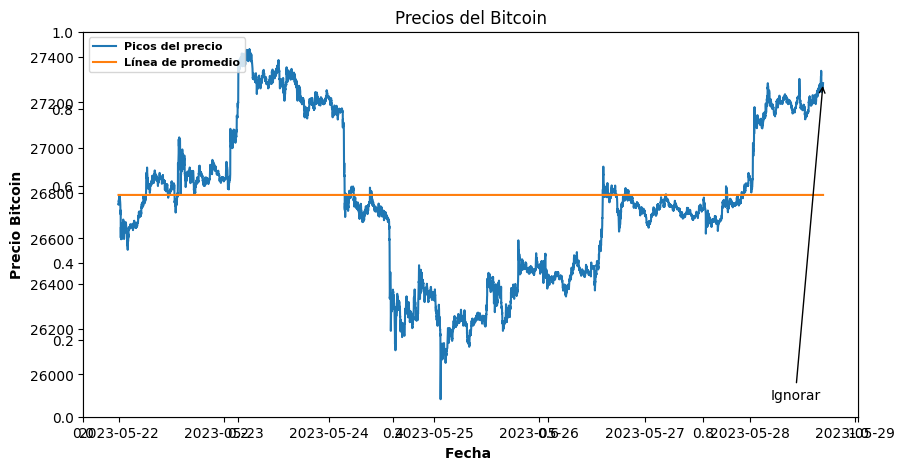

In [103]:
def visualizacion():
    # Configuración del tamaño y título del gráfico
    fig = plt.figure(figsize=(10, 5))
    plt.title('Precios del Bitcoin')
    ax = fig.add_subplot(1, 1, 1)
    
    # Agrega columna Promedio al dataframe
    df_bitcoin['Promedio'] = media_bitcoin
    
    # Configuración de etiquetas de ejes
    ax.set_xlabel('Fecha ', fontsize=10, fontweight='bold')
    ax.set_ylabel('Precio Bitcoin', fontsize=10, fontweight='bold')
    
    # Graficar función de Close
    ax.plot(df_bitcoin.index, df_bitcoin["Close"], label='Picos del precio')
    
    # Graficar línea de Promedio
    ax.plot(df_bitcoin.index, df_bitcoin["Promedio"], label='Línea de promedio')
    
    # Configuración de la leyenda
    ax.legend(loc='upper left', prop={'size': 8, 'weight': 'bold'})
    
    # Mostrar mensaje con algoritmo_decision
    plt.annotate(algoritmo_decision, xy=(df_bitcoin.index[-1], df_bitcoin["Close"][-1]),
                 xytext=(df_bitcoin.index[-720], df_bitcoin["Close"].min()),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    
    # Mostrar el gráfico
    plt.show()

visualizacion()


Finalmente un loop infinito para ejecutar permanentemente y en intervalos de 5minutos, las funciones construidas de nuestro proyecto, de la siguiente forma:

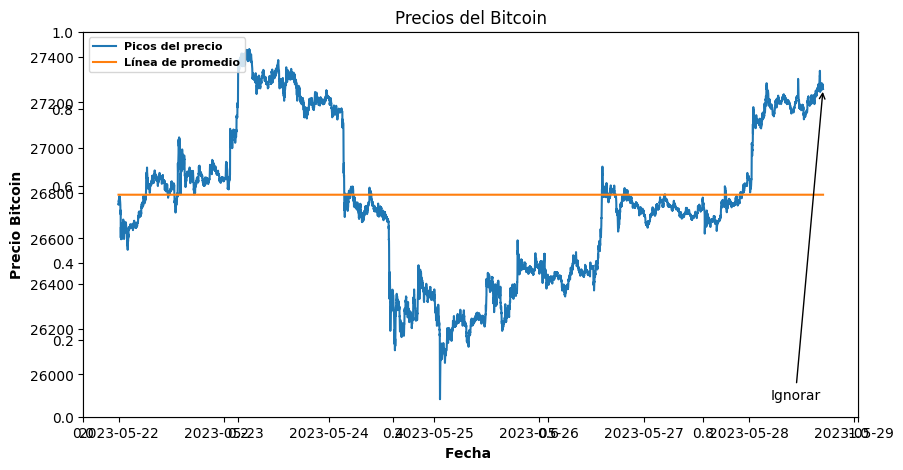

KeyboardInterrupt: ignored

In [116]:
contador = 0
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)
  contador += 1
  if contador == 2:
    break